In [1]:
import pandas as pd
import re
from unidecode import unidecode
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import LdaModel
from nltk.util import ngrams
from collections import Counter
import seaborn as sns
import numpy as np 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from itertools import chain  
import networkx as nx

In [2]:
df = pd.read_json("FIRE_cleaned_data.json", lines=True)

# Sentimental Analysis

In [3]:
# VADER 
analyzer = SentimentIntensityAnalyzer()

# Create a function to calculate sentiment scores
def get_sentiment_scores(tokens):
    # Combine the lemmatized tokens back into a text
    text = ' '.join(tokens)
    
    # Calculate sentiment scores
    sentiment = analyzer.polarity_scores(text)
    compound_score = sentiment['compound']
    
    if compound_score >= 0.05:
        sentiment_label = 'Positive'
    elif compound_score <= -0.05:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'
    
    return compound_score, sentiment_label

# Calculate sentiment scores for each row and store them in new columns
df[['vader_compound_score', 'vader_sentiment']] = df['lemmatized_tokens'].apply(get_sentiment_scores).apply(pd.Series)


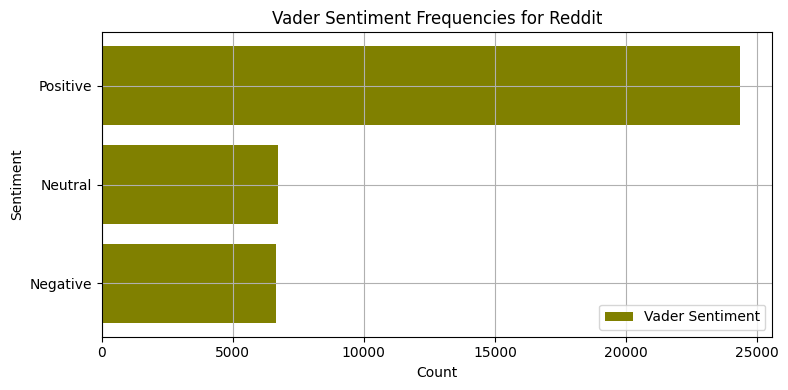

In [4]:
vader_sentiment_counts = df.groupby('vader_sentiment').size()

# Create a single graph for sentiment and Vader sentiment vs frequency
plt.figure(figsize=(8, 4))

# Plot Vader sentiment counts
plt.barh(vader_sentiment_counts.index, vader_sentiment_counts.values, color='olive', label='Vader Sentiment')

plt.xlabel('Count')
plt.ylabel('Sentiment')
plt.title('Vader Sentiment Frequencies for Reddit')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

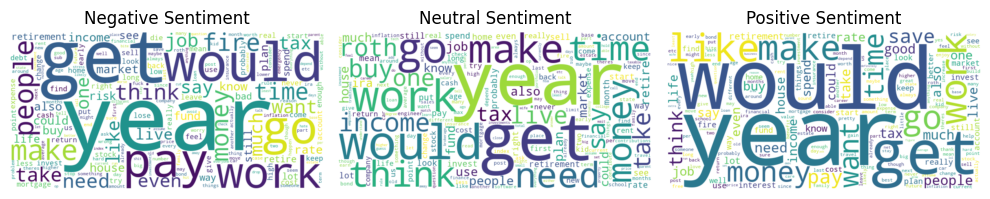

In [5]:
# Group data by sentiment and merge tokens
grouped = df.groupby('vader_sentiment')['lemmatized_tokens'].apply(lambda x: [token for sublist in x for token in sublist])

# Count word frequencies in each sentiment group
word_counts = {sentiment: Counter(tokens) for sentiment, tokens in grouped.items()}

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

# Create word clouds for each sentiment group and display in subplots
for i, (sentiment, counts) in enumerate(word_counts.items()):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counts)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'{sentiment.capitalize()} Sentiment')
    axes[i].axis('off')

# Adjust layout spacing
plt.tight_layout()
plt.show()

More cleaning

In [6]:
# Define a list of words to remove
remove_words = ['would', 'get', 'year', 'go', 'sense', 'sure', 'like', 'seem', 'sound', 'thank']

# Apply a lambda function to remove specified words
df['cleaned_lemmatized_tokens'] = df['lemmatized_tokens'].apply(lambda tokens: [word for word in tokens if word not in remove_words])


# Topic modelling

In [7]:
# Function to create n-grams with space-separated tokens
def create_space_separated_bigrams(text):
    tokens = word_tokenize(text)
    bigrams = list(ngrams(tokens, 2))
    return [' '.join(bigram) for bigram in bigrams]

# Assuming df1 has a column named 'lemmatized_filtered_tokens'
df['space_separated_bigrams'] = df['cleaned_lemmatized_tokens'].apply(lambda tokens: create_space_separated_bigrams(' '.join(tokens)))

BOW method

In [8]:
dictionary = corpora.Dictionary(df['space_separated_bigrams'])

# Create a corpus (bag of words representation) from the unigrams
corpus = [dictionary.doc2bow(bigram) for bigram in df['space_separated_bigrams']]

# Build the LDA model
lda_model_bow = LdaModel(corpus, num_topics= 4, id2word=dictionary, passes=15)

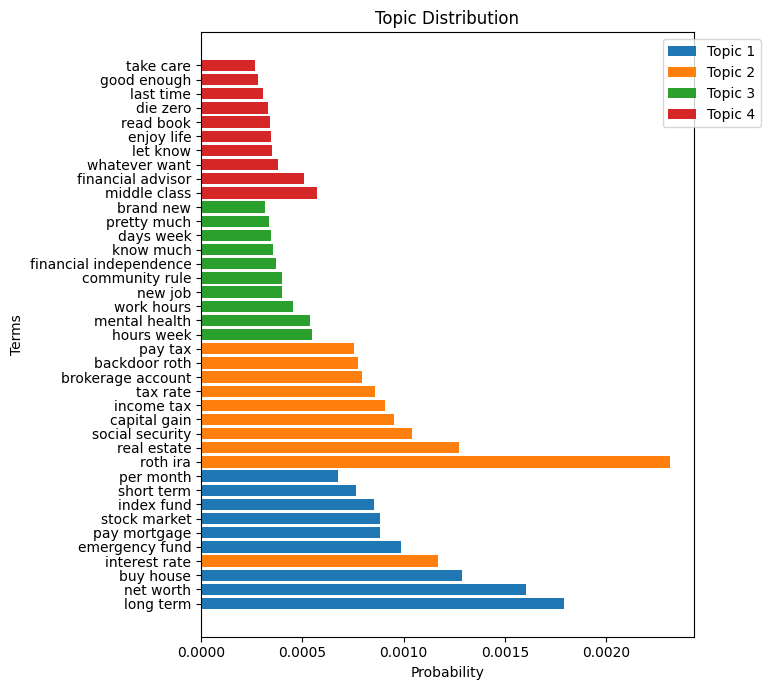

In [9]:
# Get the topic-term matrix
topic_terms = lda_model_bow.get_topics()

# Normalize the topic-term matrix
topic_terms /= topic_terms.sum(axis=1)[:, np.newaxis]

# Get the top terms for each topic
num_top_terms = 10  # You can adjust the number of top terms
top_terms_per_topic = [lda_model_bow.show_topic(topic_id, topn=num_top_terms) for topic_id in range(4)]

# Adjust figure size
plt.figure(figsize=(8,7))

# Create a bar plot for each topic
for topic_id, top_terms in enumerate(top_terms_per_topic):
    terms, probabilities = zip(*top_terms)
    plt.barh(terms, probabilities, label=f"Topic {topic_id + 1}")

plt.xlabel('Probability')
plt.ylabel('Terms')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.title('Topic Distribution')
plt.tight_layout()
plt.show()


In [10]:
for topic_id, top_terms in enumerate(top_terms_per_topic):
    terms, _ = zip(*top_terms)  # Ignore the probabilities
    print(f"Topic {topic_id + 1} :\n {terms}")

Topic 1 :
 ('long term', 'net worth', 'buy house', 'interest rate', 'emergency fund', 'pay mortgage', 'stock market', 'index fund', 'short term', 'per month')
Topic 2 :
 ('roth ira', 'real estate', 'interest rate', 'social security', 'capital gain', 'income tax', 'tax rate', 'brokerage account', 'backdoor roth', 'pay tax')
Topic 3 :
 ('hours week', 'mental health', 'work hours', 'new job', 'community rule', 'financial independence', 'know much', 'days week', 'pretty much', 'brand new')
Topic 4 :
 ('middle class', 'financial advisor', 'whatever want', 'let know', 'enjoy life', 'read book', 'die zero', 'last time', 'good enough', 'take care')


Making Graph

In [11]:
selected_df = df[['comment_author', 'space_separated_bigrams']]

# Now you can use the selected_df DataFrame in the previous code to create the bigram_user_dict

# Create an empty dictionary to store the results
bigram_user_dict = {bigram: [] for sublist in top_terms_per_topic for bigram, _ in sublist}

# Iterate through the selected_df rows
for index, row in selected_df.iterrows():
    user_id = row['comment_author']
    bigram_list = row['space_separated_bigrams']
    
    if isinstance(bigram_list, list):
        for bigram in bigram_list:
            # Iterate through the user's bigrams and check if they match any in the top_terms_per_topic
            for top_bigram, _ in bigram_user_dict.items():
                if bigram in top_bigram:
                    bigram_user_dict[top_bigram].append(user_id)

# Filter out empty lists and convert to a more readable dictionary
bigram_user_dict = {bigram: users for bigram, users in bigram_user_dict.items() if users}


In [12]:
topic_bigrams = {}

# Iterate through the topics and their top bigrams
for topic_id, top_bigrams in enumerate(top_terms_per_topic):
    # Assuming each entry in top_bigrams is a tuple (bigram, probability)
    # Extract just the bigram from each entry
    bigrams_for_topic = [bigram for bigram, _ in top_bigrams]
    
    # Store the list of bigrams in the dictionary with the topic as the key
    topic_bigrams[topic_id] = bigrams_for_topic

In [13]:
# Create a graph
G = nx.Graph()

# Create nodes for topics, bigrams, and user_ids
topics = list(topic_bigrams.keys())
bigrams = [bigram for bigrams in topic_bigrams.values() for bigram in bigrams]
user_ids = [user_id for bigram in bigrams for user_id in bigram_user_dict.get(bigram, [])]

G.add_nodes_from(topics, node_type="topic")
G.add_nodes_from(bigrams, node_type="bigram")
G.add_nodes_from(user_ids, node_type="user_id")

# Create edges connecting topics, bigrams, and user_ids
for topic, topic_bigram_list in topic_bigrams.items():
    for bigram in topic_bigram_list:
        G.add_edge(topic, bigram)
        for user_id in bigram_user_dict.get(bigram, []):
            G.add_edge(bigram, user_id)


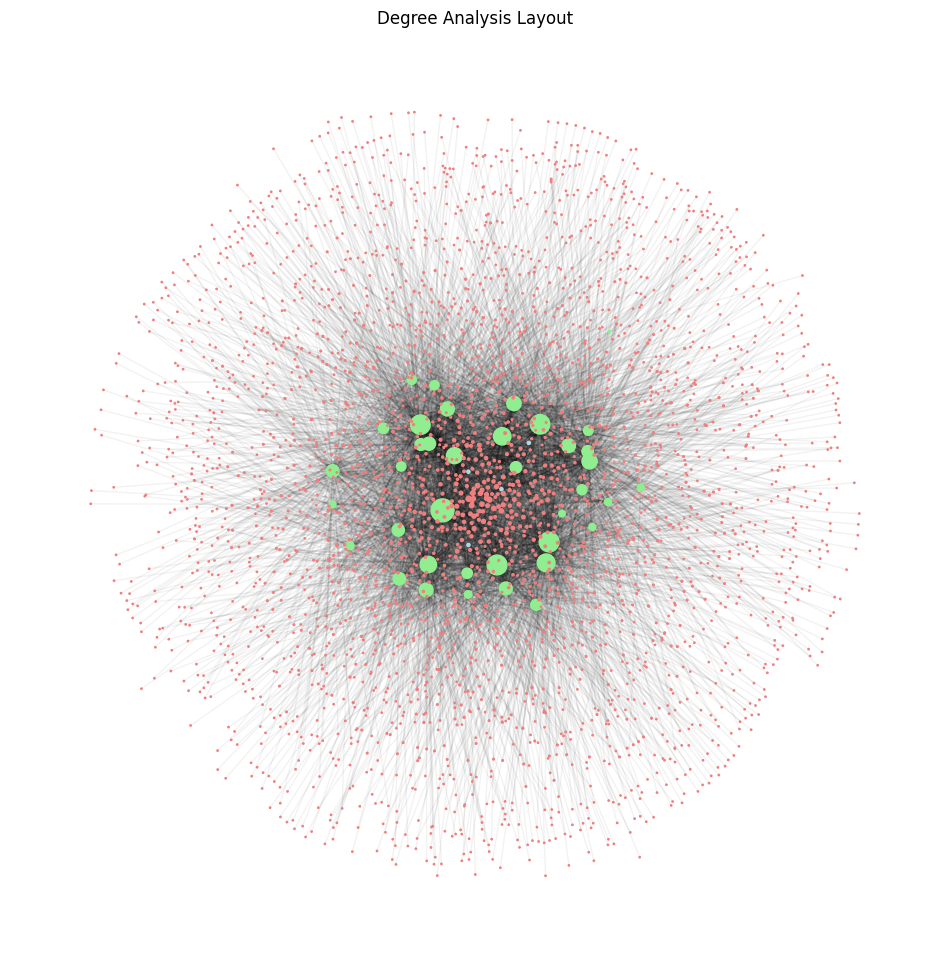

In [14]:
# Calculate node degrees
node_degrees = dict(G.degree())

# Define the position for each node, where node size is proportional to its degree
pos = nx.spring_layout(G, k=0.15, iterations=50, seed=42)

# Create a dictionary to map colors to node types
node_colors = {"topic": 'lightblue', "bigram": 'lightgreen', "user_id": 'lightcoral'}
colors = [node_colors[data['node_type']] for node, data in G.nodes(data=True)]

plt.figure(figsize=(12, 12))

# Draw nodes with sizes based on degree
node_size = [0.5 * (1 + node_degrees[node]) for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=node_size)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.05)


plt.axis('off')  # Turn off the axis
plt.title("Degree Analysis Layout")
plt.show()